In [1]:
Project = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Projects/Adipocyte'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.rcParams.update(plt.rcParamsDefault)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

plt.rcParams['ps.useafm']=True
plt.rcParams['pdf.fonttype']=42

plt.rc('font', size=7)          # controls default text sizes
plt.rc('axes', titlesize=7)     # fontsize of the axes title
plt.rc('axes', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
plt.rc('legend', fontsize=6)    # legend fontsize
suptitlesize = 7

plt.rc('axes', axisbelow=True) #push axes to back
mpl.rcParams['axes.linewidth'] = 0.5
# plt.rcParams['axes.facecolor']='#E7E8E9'

In [2]:
RD = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RD_avg_log2FC.tsv', sep='\t').rename(columns={'D4':'RD4', 'D8':'RD8'})
RNA = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RNA_avg_log2FC.tsv', sep='\t')
RPF = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RPF_avg_log2FC.tsv', sep='\t')

logFC = {}
logFC['RD'] = RD
logFC['RNA'] = RNA
logFC['RPF'] = RPF

# display(logFC['RD'])

In [3]:
MitoCarta3_file = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/MITOCARTA3.0/Mouse.MitoCarta3.0.xls'
MitoCarta = pd.read_excel(MitoCarta3_file, 'A Mouse MitoCarta3.0')
MitoPW    = pd.read_excel(MitoCarta3_file, 'C MitoPathways')

name2EnsgID = MitoCarta[['Symbol','EnsemblGeneID']].set_index('Symbol')['EnsemblGeneID'].to_dict()
mito_genes = MitoCarta[['EnsemblGeneID']].drop_duplicates().rename(columns={'EnsemblGeneID':'gene_id'})

MitoPW['PW level'] = MitoPW['MitoPathway Hierarchy'].str.split('>').str.len()
MitoPW['gene_ids'] = ''
for i in range(len(MitoPW)):

    # Collecting Ensembl gene IDs
    for gene in MitoPW.iloc[i,:]['Genes'].split(', '):
        if type(name2EnsgID[gene]) == float : continue
        MitoPW.iloc[i,4] += name2EnsgID[gene].replace('|',',') + ','
    MitoPW.iloc[i,4] = MitoPW.iloc[i,4][:-1]

MitoPW = MitoPW.set_index('MitoPathway',drop=True)


OXPHOS = pd.DataFrame({'gene_id' : MitoPW.loc['OXPHOS subunits','gene_ids'].split(',')})
C2 = pd.DataFrame({'gene_id' : MitoPW.loc['Complex II','gene_ids'].split(',')})
TCA = pd.DataFrame({'gene_id' : MitoPW.loc['TCA cycle','gene_ids'].split(',')})

mtDNA = MitoCarta[['Symbol','EnsemblGeneID']]
mtDNA = mtDNA[mtDNA['Symbol'].str.startswith('mt-')].reset_index(drop=True)
mtDNA = mtDNA.rename(columns={'Symbol':'gene_name', 'EnsemblGeneID':'gene_id'})[['gene_id']]
# display(mtDNA)

tmp = pd.merge(mito_genes, mtDNA, on='gene_id', how='outer', indicator=True).sort_values('_merge')
mito_genes_nc = tmp[tmp['_merge']=='left_only'].drop(columns='_merge')[['gene_id']]

tmp = pd.merge(OXPHOS, mtDNA, on='gene_id', how='outer', indicator=True).sort_values('_merge')
OXPHOS_nc = tmp[tmp['_merge']=='left_only'].drop(columns='_merge')[['gene_id']]
OXPHOS_mt = tmp[tmp['_merge']=='both'].drop(columns='_merge')[['gene_id']]
# display(OXPHOS_nc,OXPHOS_mt)

tmp = MitoCarta[['Symbol','EnsemblGeneID','MitoCarta3.0_SubMitoLocalization']].rename(columns={'EnsemblGeneID':'gene_id'})
mito_local = {}
for local in ['MIM','Matrix','MOM','IMS']:
    mito_local[local] = tmp[[local in i for i in tmp['MitoCarta3.0_SubMitoLocalization']]][['gene_id']]

In [4]:
import csv

gmt_path = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/GSEA/gmt/m5.go.v2023.1.Mm.symbols.gmt'

gmt = {}
rf = open(gmt_path)
reader = csv.reader(rf, delimiter='\t')
for line in reader:
    gmt[line[0]] = line[2:]
rf.close()

conv = pd.read_csv('/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/GSEA/chip/Mouse_Ensembl_Gene_ID_MSigDB.v2023.2.Mm.chip', sep='\t')
conv = conv.drop(columns='Gene Title').rename(columns={'Probe Set ID':'gene_id', 'Gene Symbol':'gene_name'})
# display(conv)

GO_term = {
    'GOCC_CYTOSOLIC_RIBOSOME' : pd.merge(conv, pd.DataFrame({'gene_name':gmt['GOCC_CYTOSOLIC_RIBOSOME']}), on='gene_name')[['gene_id']].drop_duplicates(),
}

In [5]:
APEX = pd.read_excel(f'{Project}/Results/Other_papers/Fazal_Han_etal.,2019,cell/Tables/Resources/(Sup. table4) Atlas of subcellular RNA localization revealed by APEX-seq_Cell_2019.xlsx', sheet_name='OMM APEX-seq data')
CHIP = pd.read_csv('/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/GSEA/chip/Mouse_Ensembl_Gene_ID_Human_Orthologs_MSigDB.v2023.2.Hs.chip', sep='\t', usecols=['Probe Set ID','Gene Symbol']).rename(columns={'Probe Set ID':'gene_id', 'Gene Symbol':'Common_Gene'})

APEX2 = pd.merge(CHIP, APEX[['Common_Gene','Basal_L2FC','Puromycin_L2FC','Cycloheximide_L2FC','Mito_TargetP_score']], on='Common_Gene').sort_values('gene_id').drop_duplicates(subset='gene_id')

APEX3 = pd.merge(APEX2[['gene_id','Basal_L2FC','Puromycin_L2FC','Cycloheximide_L2FC','Mito_TargetP_score']], logFC['RD'], on='gene_id')
APEX3 = pd.merge(APEX3, logFC['RNA'].drop(columns='gene_name'), on='gene_id')
APEX3 = pd.merge(APEX3, logFC['RPF'].drop(columns='gene_name'), on='gene_id')

# filt mtDNA genes
tmp = pd.merge(APEX3, mtDNA, on='gene_id', how='outer', indicator=True).sort_values('_merge')
APEX3 = tmp[tmp['_merge']=='left_only'].drop(columns='_merge')

APEX3_cyto = pd.merge(APEX3, mito_genes_nc, on='gene_id', how='left', indicator=True)
APEX3_cyto = APEX3_cyto[APEX3_cyto['_merge']=='left_only'].drop(columns='_merge')

APEX3_mito = pd.merge(APEX3, mito_genes_nc, on='gene_id')

# display(APEX3, APEX3_cyto, APEX3_mito)
APEX3 = APEX3.sample(frac=1).reset_index(drop=True)
APEX3_cyto = APEX3_cyto.sample(frac=1).reset_index(drop=True)
APEX3_mito = APEX3_mito.sample(frac=1).reset_index(drop=True)

---

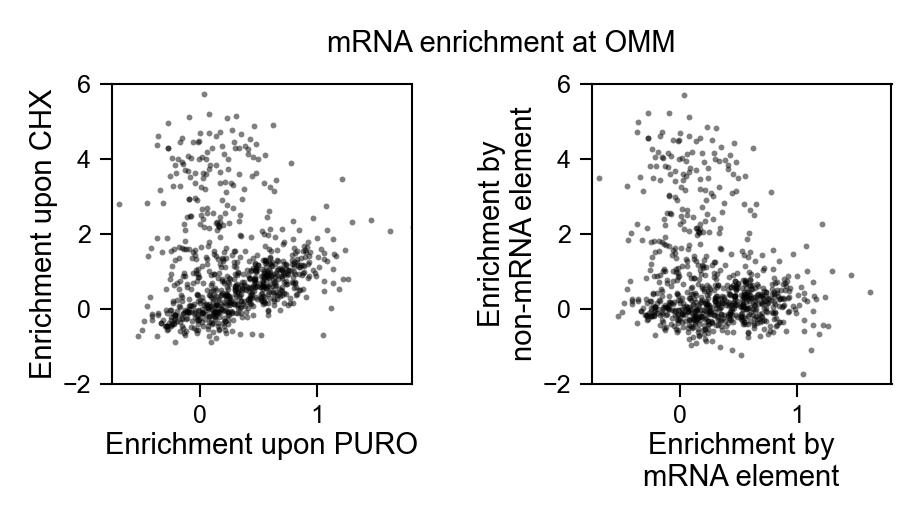

<Figure size 640x480 with 0 Axes>

In [6]:
sF = 1 # Size factor
wgap = 0.6
hgap = 0
nrow, ncol = 1, 2

height_ratios = [1]
width_ratios = [1, 1]

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)


APEX3_tmp = APEX3_mito.copy()
APEX3_tmp['Post-init'] = APEX3_mito['Cycloheximide_L2FC']-APEX3_mito['Puromycin_L2FC']


ax = fig.add_subplot(grid[0,0])

x = 'Puromycin_L2FC'
y = 'Cycloheximide_L2FC'

ax.scatter(APEX3_tmp[x], APEX3_tmp[y], 
           c='k',
           s=2, alpha=0.5, 
           lw=0,
           rasterized=True)

ax.set_xlim(-0.75, 1.8)
ax.set_ylim(-2, 6)
ax.set_xticks([0, 1])
ax.set_yticks([-2, 0, 2, 4, 6])
ax.tick_params(width=0.5, length=3, pad=2)

# ax.set_title('mRNA enrichment at OMM')
ax.set_xlabel('Enrichment upon PURO', labelpad=1)
ax.set_ylabel('Enrichment upon CHX', labelpad=1)


ax = fig.add_subplot(grid[0,1])

x = 'Puromycin_L2FC'
y = 'Post-init' # Puromycin_L2FC Cycloheximide_L2FC Basal_L2FC

ax.scatter(APEX3_tmp[x], APEX3_tmp[y], 
           c='k',
           s=2, alpha=0.5, 
           lw=0,
           rasterized=True)

ax.set_xlim(-0.75, 1.8)
ax.set_ylim(-2, 6)
ax.set_xticks([0, 1])
ax.set_yticks([-2, 0, 2, 4, 6])
ax.tick_params(width=0.5, length=3, pad=2)

ax.set_xlabel('Enrichment by\nmRNA element', labelpad=1)
ax.set_ylabel('Enrichment by\nnon-mRNA element', labelpad=1)

plt.suptitle('mRNA enrichment at OMM', fontsize=7, y=1.18)

plt.savefig('OMM-proxy_scatter.pdf', bbox_inches='tight')
plt.show()
plt.clf()

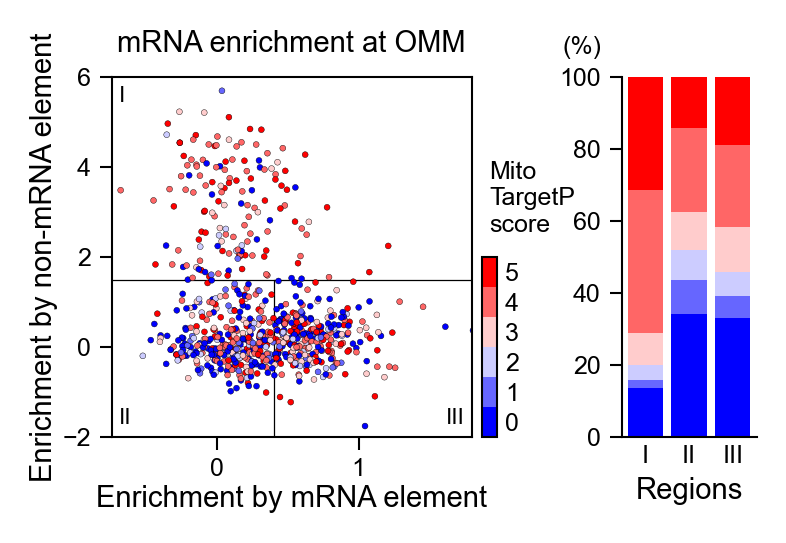

<Figure size 640x480 with 0 Axes>

In [7]:
def discrete_cmap(N, base_cmap=None): # https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    base = mpl.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

sF = 1 # Size factor
wgap = 0.5
hgap = 0
nrow, ncol = 1, 2

height_ratios = [1.2]
width_ratios = [1.2, 0.45]

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)


# Scatter
ax = fig.add_subplot(grid[0,0])

APEX3_tmp = APEX3_mito.copy()
APEX3_tmp['Post-init'] = APEX3_mito['Cycloheximide_L2FC']-APEX3_mito['Puromycin_L2FC']

x = 'Puromycin_L2FC'
y = 'Post-init' # Puromycin_L2FC Cycloheximide_L2FC Basal_L2FC

# ax.set_facecolor('#DDDDDD')
ax.axhline(1.5, c='k', lw=0.3, zorder=-1)
ax.plot([0.4,0.4],[-2,1.5], c='k', lw=0.3, zorder=-1)

sct = ax.scatter(APEX3_tmp[x], APEX3_tmp[y], 
                c=APEX3_tmp['Mito_TargetP_score'], cmap=discrete_cmap(6,'bwr'), vmin=-0.5, vmax=5.5, 
                s=2, alpha=1, 
                lw=0.1, edgecolors='k',
                rasterized=True)
ax.text(-0.75+0.05, 6-0.2, 'I', ha='left', va='top', fontsize=5.5)
ax.text(-0.75+0.05, -2+0.2, 'II', ha='left', va='bottom', fontsize=5.5)
ax.text(1.8-0.05, -2+0.2, 'III', ha='right', va='bottom', fontsize=5.5)

ax.set_xlim(-0.75, 1.8)
ax.set_ylim(-2, 6)
ax.set_xticks([0, 1])
ax.set_yticks([-2, 0, 2, 4, 6])
ax.tick_params(width=0.5, length=3, pad=2)

ax.set_title('mRNA enrichment at OMM')
ax.set_xlabel('Enrichment by mRNA element', labelpad=1)
ax.set_ylabel('Enrichment by non-mRNA element', labelpad=1)

cbar = plt.colorbar(sct, ax=ax, cax = ax.inset_axes([1.03, 0, 0.04, 0.5]), orientation='vertical')
cbar.ax.set_title('Mito\nTargetP\nscore', ha='left', fontsize=6)
cbar.ax.set_yticks([*range(6)])
cbar.ax.tick_params(length=0, pad=2)


# box plot
Regions = []
for pur, post in zip(APEX3_tmp['Puromycin_L2FC'], APEX3_tmp['Post-init']):
    if post > 1.5 :
        if pur >= 0.4 :
            Regions.append('R1')
        else :
            Regions.append('R1')
    else :
        if pur < 0.4 :
            Regions.append('R2')
        else :
            Regions.append('R3')
APEX3_tmp['Region'] = Regions
APEX3_tmp['Region'] = pd.Categorical(APEX3_tmp['Region'], categories=['R1','R2','R3'])

tmp = []
for score, df in APEX3_tmp[['Region','Mito_TargetP_score']].dropna().groupby('Mito_TargetP_score'):
    tmp.append(pd.DataFrame(df.value_counts('Region')).rename(columns={0:score}))
tmp = pd.concat(tmp, axis=1).T
tmp = tmp[['R1','R2','R3']]
for col in tmp: tmp[col] = tmp[col] / sum(tmp[col]) * 100

ax2 = fig.add_subplot(grid[0,1])

bottom = [0,0,0]
for score, color in zip(tmp.T, ['#0000FF','#6666FF','#CCCCFF','#FFCCCC','#FF6666','#FF0000']):
    values = list(tmp.T[score])
    ax2.bar([0,1,2], values, bottom=bottom, color=color)

    bottom = [a+b for a,b in zip(bottom, values)]

ax2.set_ylim(0, 100)
ax2.set_xticks([0,1,2])
ax2.set_xticklabels(['I','II','III'])
ax2.tick_params(width=0.5, length=3, pad=2)
ax2.tick_params(axis='x', length=0, pad=2)
ax2.set_xlabel('Regions', labelpad=2)
ax2.text(-1, 105, '(%)', fontsize=6, ha='right', va='bottom', clip_on=False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)

plt.savefig('OMM-APEXseq_mtTargetPscore_scatter-bar_mito.pdf', bbox_inches='tight')
plt.show()
plt.clf()

/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_41622/2429006181.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=APEX3_tmp, x='Region', y='RD8',
/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_41622/2429006181.py:83: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=APEX3_tmp, x='Region', y='RD8',


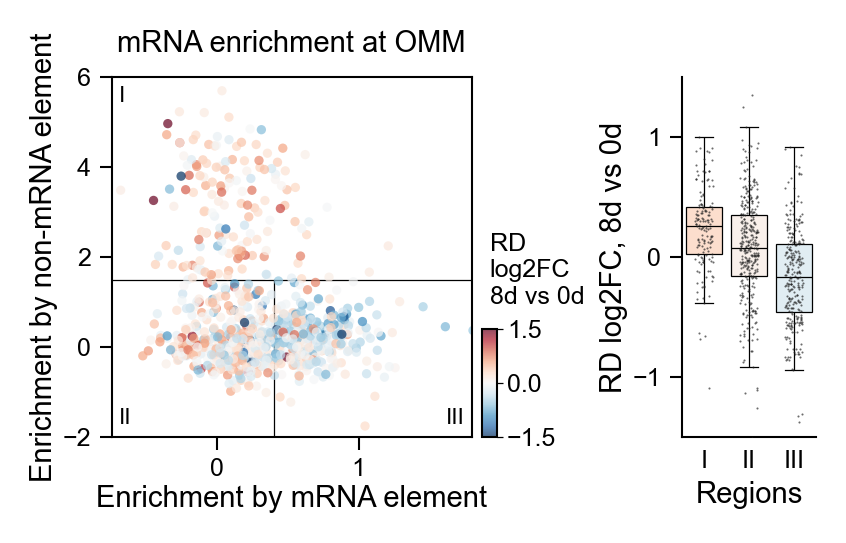

<Figure size 640x480 with 0 Axes>

In [8]:
sF = 1 # Size factor
wgap = 0.7
hgap = 0
nrow, ncol = 1, 2

height_ratios = [1.2]
width_ratios = [1.2, 0.45]

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)


# Scatter
ax = fig.add_subplot(grid[0,0])

APEX3_tmp = APEX3_mito.copy()
APEX3_tmp['Post-init'] = APEX3_mito['Cycloheximide_L2FC']-APEX3_mito['Puromycin_L2FC']
# APEX3_tmp = APEX3_tmp.sample(frac=1)

x = 'Puromycin_L2FC'
y = 'Post-init' # Puromycin_L2FC Cycloheximide_L2FC Basal_L2FC

# ax.set_facecolor('#DDDDDD')
ax.axhline(1.5, c='k', lw=0.3, zorder=-1)
ax.plot([0.4,0.4],[-2,1.5], c='k', lw=0.3, zorder=-1)

sct = ax.scatter(APEX3_tmp[x], APEX3_tmp[y], 
                c=APEX3_tmp['RD8'], cmap='RdBu_r', vmin=-1.5, vmax=1.5, 
                s=5, alpha=0.7, 
                lw=0, edgecolors='k',
                rasterized=True)
ax.text(-0.75+0.05, 6-0.2, 'I', ha='left', va='top', fontsize=5.5)
ax.text(-0.75+0.05, -2+0.2, 'II', ha='left', va='bottom', fontsize=5.5)
ax.text(1.8-0.05, -2+0.2, 'III', ha='right', va='bottom', fontsize=5.5)

ax.set_xlim(-0.75, 1.8)
ax.set_ylim(-2, 6)
ax.set_xticks([0, 1])
ax.set_yticks([-2, 0, 2, 4, 6])
ax.tick_params(width=0.5, length=3, pad=2)

ax.set_title('mRNA enrichment at OMM')
ax.set_xlabel('Enrichment by mRNA element', labelpad=1)
ax.set_ylabel('Enrichment by non-mRNA element', labelpad=1)

cbar = plt.colorbar(sct, ax=ax, cax = ax.inset_axes([1.03, 0, 0.04, 0.3]), orientation='vertical')
cbar.ax.set_title('RD\nlog2FC\n8d vs 0d', ha='left', fontsize=6)
cbar.ax.set_yticks([-1.5,0,1.5])
cbar.ax.tick_params(width=0.3, length=1.5, pad=1)

# box plot
Regions = []
for pur, post in zip(APEX3_tmp['Puromycin_L2FC'], APEX3_tmp['Post-init']):
    if post > 1.5 :
        if pur >= 0.4 :
            Regions.append('R1')
        else :
            Regions.append('R1')
    else :
        if pur < 0.4 :
            Regions.append('R2')
        else :
            Regions.append('R3')
APEX3_tmp['Region'] = Regions
APEX3_tmp['Region'] = pd.Categorical(APEX3_tmp['Region'], categories=['R1','R2','R3'])

ax2 = fig.add_subplot(grid[0,1])

# Facecolors of boxes using median values
clim = [-1.5, 1.5]
c = np.array([APEX3_tmp[APEX3_tmp['Region']==Q]['RD8'].median() for Q in ['R1','R2','R3']]) 
facecolors = mpl.cm.RdBu_r((c-clim[0]) / (clim[1]-clim[0]))

sns.boxplot(data=APEX3_tmp, x='Region', y='RD8',
            fill=True, palette=facecolors, saturation=1,
            width=0.9, gap=0.1,
            fliersize=0,
            # showmeans=True, meanprops={'marker':'D', 'markerfacecolor':'k', 'markeredgewidth':'0', 'markersize':'2'},
            ax=ax2, linewidth = 0.3, linecolor='k',
            legend=False)
st1 = sns.stripplot(data=APEX3_tmp, x='Region', y='RD8',
                    color = '#222222AA', 
                    size = 0.5,
                    jitter= 0.2,
                    ax=ax2, linewidth = 0,
                    legend=False, rasterized=True)

ax2.set_ylim(-1.5, 1.5)
ax2.set_yticks([-1,0,1])
ax2.set_xticks(range(3))
ax2.set_xticklabels(['I','II','III'])
ax2.tick_params(width=0.5, length=3, pad=2)
ax2.tick_params(axis='x', length=0, pad=3)
ax2.set_xlabel('Regions', labelpad=2)
ax2.set_ylabel('RD log2FC, 8d vs 0d', labelpad=1)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)

plt.savefig('OMM-APEXseq_RDlogFC_scatter-box_mito.pdf', bbox_inches='tight')
plt.show()
plt.clf()

In [10]:
from scipy.stats import ks_2samp

print(ks_2samp(APEX3_tmp[APEX3_tmp['Region']=='R1']['RD8'], APEX3_tmp[APEX3_tmp['Region']=='R2']['RD8']))
print(ks_2samp(APEX3_tmp[APEX3_tmp['Region']=='R1']['RD8'], APEX3_tmp[APEX3_tmp['Region']=='R3']['RD8']))
print(ks_2samp(APEX3_tmp[APEX3_tmp['Region']=='R2']['RD8'], APEX3_tmp[APEX3_tmp['Region']=='R3']['RD8']))

KstestResult(statistic=0.22634192932187203, pvalue=3.319031426685188e-05)
KstestResult(statistic=0.4555399061032864, pvalue=6.240694378565611e-19)
KstestResult(statistic=0.2682513418620606, pvalue=2.0273875870666072e-10)


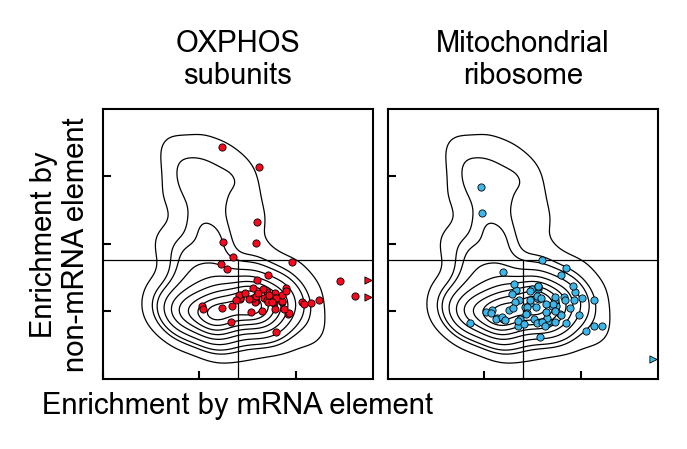

<Figure size 640x480 with 0 Axes>

In [9]:
GS_dict = {
    'OXPHOS subunits' : OXPHOS,
    # 'TCA cycle' : TCA,
    'Mitochondrial ribosome' : pd.DataFrame({'gene_id' : MitoPW.loc['Mitochondrial ribosome','gene_ids'].split(',')}),

    # 'Fatty acid oxidation' : pd.DataFrame({'gene_id' : MitoPW.loc['Fatty acid oxidation','gene_ids'].split(',')}),

    # 'mt-tRNA synthetases' : pd.DataFrame({'gene_id' : MitoPW.loc['mt-tRNA synthetases','gene_ids'].split(',')}),
    # 'Proteases' : pd.DataFrame({'gene_id' : MitoPW.loc['Proteases','gene_ids'].split(',')}),
    # 'Amino acid metabolism' : pd.DataFrame({'gene_id' : MitoPW.loc['Amino acid metabolism','gene_ids'].split(',')}),
    # 'Vitamin metabolism' : pd.DataFrame({'gene_id' : MitoPW.loc['Vitamin metabolism','gene_ids'].split(',')}),
    # 'mtRNA metabolism' : pd.DataFrame({'gene_id' : MitoPW.loc['mtRNA metabolism','gene_ids'].split(',')}),

    # 'Calcium homeostasis' : pd.DataFrame({'gene_id' : MitoPW.loc['Calcium homeostasis','gene_ids'].split(',')}),

    # 'Purine nucleotide binding' : GO_term['GOMF_PURINE_NUCLEOTIDE_BINDING'],
    # 'Adenyl nucleotide binding' : GO_term['GOMF_ADENYL_NUCLEOTIDE_BINDING'],
    # 'Ligase activity' : GO_term['GOMF_LIGASE_ACTIVITY'],

    # 'OMM' : mito_local['MOM'],
    # 'IMS' : mito_local['IMS'],
    # 'IMM' : mito_local['MIM'],
    # 'Matrix' : mito_local['Matrix'],
}
colors = {
    # 'Mito. protein-coding genes' : 'r',
    'OXPHOS subunits' : '#F8071D',
    # 'OXPHOS subunits (nDNA)' : 'red',
    # 'Complex II' : 'cyan',
    # 'TCA cycle' : 'magenta', # magenta
    'Mitochondrial ribosome' : '#3DB7E9',

    'Fatty acid oxidation' : '#FF8D1A',
    'mt-tRNA synthetases' : '#FF8D1A',
    'Proteases' : '#FF8D1A',
    'Amino acid metabolism' : '#FF8D1A',
    'Vitamin metabolism' : '#FF8D1A',
    'mtRNA metabolism' : '#FF8D1A',
    'Calcium homeostasis' : '#FF8D1A',

    'Purine nucleotide binding' : '#FF8D1A',
    'Adenyl nucleotide binding' : '#FF8D1A',
    'Ligase activity' : '#FF8D1A',

    'OMM' : '#FF8D1A',
    'IMS' : '#FF8D1A',
    'IMM' : '#FF8D1A',
    'Matrix' : '#FF8D1A',
}

sF = 1 # Size factor
wgap = 0.05
hgap = 0
nrow, ncol = 1, 2

height_ratios = [0.9]*nrow
width_ratios = [0.9]*ncol

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)


row = 0
col = 0

for GS in GS_dict:
    ax = fig.add_subplot(grid[0,col])

    APEX3_tmp = APEX3_mito.copy()
    APEX3_tmp['Post-init'] = APEX3_mito['Cycloheximide_L2FC']-APEX3_mito['Puromycin_L2FC']

    x = 'Puromycin_L2FC'
    y = 'Post-init' # Puromycin_L2FC Cycloheximide_L2FC Basal_L2FC

    ax.axhline(1.5, c='k', lw=0.3, zorder=-1)
    ax.plot([0.4,0.4],[-2,1.5], c='k', lw=0.3, zorder=-1)


    # ax.scatter(APEX3_tmp[x], APEX3_tmp[y], 
    #         c='k',
    #         s=2, alpha=0.5, 
    #         lw=0,
    #         rasterized=True)
    sns.kdeplot(data=APEX3_tmp, x=x, y=y,
                linewidths=0.3, color='k',
                ax=ax, zorder=0)

    GS_df = pd.merge(GS_dict[GS], APEX3_tmp, on='gene_id')
    ax.scatter(GS_df[x], GS_df[y], 
                c=colors[GS],
                # c=GS_df['RD8'], cmap='bwr', vmin=-1.5, vmax=1.5,
                # s=1, alpha=1, 
                s=3, alpha=1, 
                lw=0.2, edgecolors='k',
                # lw=0.2, edgecolors=colors[GS],
                rasterized=True)
    ax.scatter([1.75]*len(GS_df[GS_df['Puromycin_L2FC']>1.8]), GS_df[GS_df['Puromycin_L2FC']>1.8][y],
                c=colors[GS],
                marker='>',
                s=3, alpha=1, 
                lw=0.2, edgecolors='k',
               )

    ax.set_xlim(-0.75, 1.8)
    ax.set_ylim(-2, 6)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 2, 4])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(width=0.5, length=2, pad=2, direction='in')

    ax.set_title(GS.replace(' ','\n'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    if col==0: 
        ax.set_xlabel('Enrichment by mRNA element', labelpad=1)
        ax.set_ylabel('Enrichment by\nnon-mRNA element', labelpad=1)

    col += 1

plt.savefig('OMM-APEXseq_terms_scatter_mito.pdf', bbox_inches='tight')
plt.show()
plt.clf()